In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from random import randint

import os 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
CLOSE = "Close_BTC"

seed = randint(0, 1000000)
seed = 718099
print(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

718099


In [3]:
file_path = '../data/federalfinancegestion/Rennes_DataChallenge2024_Cryptomarkets_dataset.xlsx'
data = pd.read_excel(file_path)

# Remove all string (object type) columns from the dataset
data_numeric = data.select_dtypes(exclude=['object'])

# Finding the column that closely matches "Close_BTC" in the numeric dataset
close_btc_column_numeric = [col for col in data_numeric.columns if "Close_BTC" in col]

close_btc_column_numeric = close_btc_column_numeric[0]
# Calculate the correlation of all columns with Close_BTC in the numeric dataset
correlation_with_close_btc_numeric = data_numeric.corr()[close_btc_column_numeric].sort_values(ascending=False)

# Extract the top 10 most correlated feature names
top_feature = correlation_with_close_btc_numeric.head(10).index.tolist()
include = top_feature

In [4]:
# Load data
dataset_pickle = '../data/federalfinancegestion/dataset.pkl'
df = pd.read_pickle(dataset_pickle)
df.fillna(0, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

start_date_training = pd.to_datetime('2017-08-01')
end_date_training = pd.to_datetime('2022-08-31')
start_date_testing = pd.to_datetime('2022-09-01')
end_date_testing = pd.to_datetime('2023-04-30')

In [5]:
train_df = df.loc[start_date_training:end_date_training]
test_df = df.loc[start_date_testing:end_date_testing]

In [6]:
# Calculating the logarithmic difference of 'Close'
df['Close_Log'] = np.log(df[CLOSE])  # First, compute the log of 'Close'
df['Log_Diff_Close'] = df['Close_Log'].diff().fillna(0)  # Then compute the difference and handle NaN

In [7]:
# Include features
train = train_df[include].values
test = test_df[include].values

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [9]:
# # # SDAE
input_layer = Input(shape=(len(include),))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(include), activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(train_scaled, train_scaled, epochs=150, batch_size=32, shuffle=True, validation_split=0.2)

# Get the encoded representation of the data
encoded_features = autoencoder.predict(train_scaled)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length), :]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of days used to predict the next day
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape inputs for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(include)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(include)))



Epoch 1/150

33/33 [==============================] - 1s 7ms/step - loss: 0.1348 - val_loss: 0.0532
Epoch 2/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0557
Epoch 3/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0217
Epoch 4/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0172
Epoch 5/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0145
Epoch 6/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0138
Epoch 7/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0147
Epoch 8/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0163
Epoch 9/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0135
Epoch 10/150
33/33 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0128
Epoch 

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(include))))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             12200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 33701 (131.64 KB)
Trainable params: 33701 (131.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.fit(X_train, y_train, batch_size=64, epochs=150)

Epoch 1/150
21/21 [==============================] - 4s 5ms/step - loss: 0.0402
Epoch 2/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 3/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 4/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 5/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 6/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 7/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/150
21/21 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 13/150
21/21 [=================

In [12]:
# Predict values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], len(include)-1))), axis=1))[:, 0]

# Slice the actual prices to align with the predictions
actual_prices_aligned = df.loc[start_date_testing:end_date_testing, CLOSE][-len(predictions):]
predictions = pd.DataFrame(predictions, index=actual_prices_aligned.index, columns=['Predicted_Close'])

# Convert actual_prices_aligned to a DataFrame
actual_prices_aligned_df = pd.DataFrame(actual_prices_aligned, columns=[CLOSE])

# Calculating the logarithm of predictions and then the logarithmic difference
actual_prices_aligned_df['Predicted_Close'] = predictions
actual_prices_aligned_df['Predicted_Close'] = np.log(actual_prices_aligned_df['Predicted_Close'])
log_diff_predicted = actual_prices_aligned_df['Predicted_Close'].diff().fillna(0)
log_diff_actual = pd.DataFrame(df["Log_Diff_Close"], index=actual_prices_aligned.index, columns=['Log_Diff_Close'])

5/5 [==============================] - 1s 3ms/step


In [57]:
backtest_df = pd.concat([log_diff_actual, log_diff_predicted], axis=1)
backtest_df.rename(columns={'Log_Diff_Close': 'Actual Log Diff Close', 'Predicted Close': 'Predicted Log Diff Close'}, inplace=True)
money = 10000
money_buy_and_hold = 10000
money_evolution = []
money_evolution_buy_and_hold = []
for i in range(len(log_diff_predicted)):
    money_buy_and_hold = money_buy_and_hold * (1 + log_diff_actual.iloc[i][0])
    money_evolution_buy_and_hold.append(money_buy_and_hold)
    if log_diff_predicted[i] > 0:
        money = money * (1 + log_diff_actual.iloc[i][0])
    else:
        money = money * (1 - log_diff_actual.iloc[i][0])
    money_evolution.append(money)

output_path = os.path.join(os.getcwd(), '../data/output', "backtest_"+CLOSE+".csv")
backtest_df.to_csv(output_path, index=False)
backtest_df

,Actual Log Diff Close,Predicted_Close
date,,
2022-09-08,0.001395,0.000000
2022-09-09,0.100396,-0.001280
2022-09-12,0.047346,0.062219
2022-09-13,-0.104497,0.053818
2022-09-14,0.002631,-0.046112
...,...,...
2023-03-20,0.011681,0.065446
2023-03-21,0.013918,0.027202
2023-03-22,-0.030875,0.025536


In [55]:
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(actual_prices_aligned, predictions))

# Calculate MAE
mae = mean_absolute_error(actual_prices_aligned, predictions)

# Calculate RMSE Log diff
rmse = math.sqrt(mean_squared_error(log_diff_actual, log_diff_predicted))

# Calculate MAE Log diff
mae = mean_absolute_error(log_diff_actual, log_diff_predicted)

# Convert predictions DataFrame column to a NumPy array and flatten
predictions_array = predictions.iloc[:, 0].to_numpy().flatten()

# Now calculate MAPE
# Ensure actual_prices_aligned is also a NumPy array for consistency
actual_prices_aligned_array = actual_prices_aligned.to_numpy()

mape = np.mean(np.abs((actual_prices_aligned_array - predictions_array) / actual_prices_aligned_array)) * 100

# Handle division by zero or NaN values
mape = np.nan_to_num(mape)


# Ensure actual_prices_aligned and predictions are correctly aligned and are numpy arrays
actual_values = actual_prices_aligned.values
predicted_values = predictions.values

# U-Theil1
u_theil1 = np.sqrt(np.sum(np.square(predicted_values - actual_values)) / np.sum(np.square(np.diff(actual_values))))

# U-Theil2
u_theil2 = (np.sqrt(np.mean(np.square(predicted_values - actual_values))) / np.sqrt(np.mean(np.square(actual_values))))


# Calculate the Dielbod-Mariano
# Error from your model
model_errors = actual_prices_aligned_array - predictions_array

# Error from a naive model (using previous value as prediction)
naive_errors = actual_prices_aligned_array - np.roll(actual_prices_aligned_array, 1)
naive_errors[0] = 0  # handle the first element which doesn't have a previous value
# Difference in errors
error_diff = model_errors - naive_errors

# Mean difference in errors
mean_diff = np.mean(error_diff)

# Variance of the differences
var_diff = np.var(error_diff)

# Number of observations
n = len(error_diff)

# Calculate DM test statistic
dm_stat = mean_diff / np.sqrt(var_diff / n)


data = {
    'Indicator Name': ['Root Mean Square Error', 'Mean Absolute Error', 'Mean Absolute Percentage Error', 
                       'U-Theil1 Statistic', 'U-Theil2 Statistic', 'Diebold-Mariano Test'],
    'Value': [rmse, mae, mape, u_theil1, u_theil2, dm_stat]
}

table = pd.DataFrame(data)


output_path = os.path.join(os.getcwd(), '../data/output', "performance_"+CLOSE+".csv")
table.to_csv(output_path, index=False)
table




,Indicator Name,Value
0,Root Mean Square Error,0.047355
1,Mean Absolute Error,0.032844
2,Mean Absolute Percentage Error,4.900057
3,U-Theil1 Statistic,66.727980
4,U-Theil2 Statistic,0.207437
5,Diebold-Mariano Test,24.612474


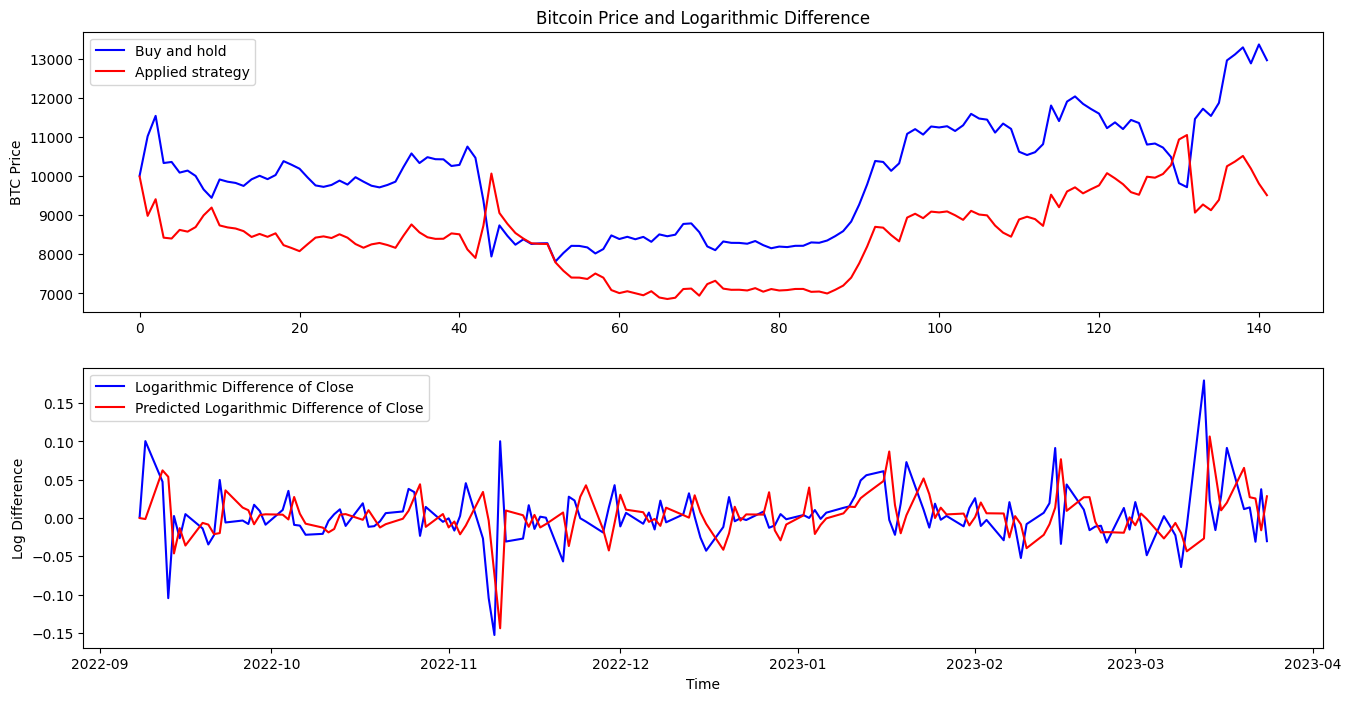

In [17]:
# Existing plot for 'Close' prices
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)  # First subplot in a 2x1 grid
plt.plot(money_evolution_buy_and_hold, label='Buy and hold', color='blue')
plt.plot(money_evolution, label='Applied strategy', color='red')
plt.title('Bitcoin Price and Logarithmic Difference')
plt.ylabel('BTC Price')
plt.legend()

# New plot for 'Log_Diff_Close'
plt.subplot(2, 1, 2)  # Second subplot in a 2x1 grid
plt.plot(log_diff_actual, label='Logarithmic Difference of Close', color='blue')
plt.plot(log_diff_predicted, label='Predicted Logarithmic Difference of Close', color='red')
plt.xlabel('Time')
plt.ylabel('Log Difference')
plt.legend()

plt.show()